In [1]:
# Lets start by converting book, rating users into the appropriate rows and cols.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pprint



DATA_CONTEXT = "games"
VERSION = "2"
OUTPUT = "data"
# Load the data

products_df_original = pd.read_csv("../data/downsized_games/games.csv")
users_df_original = pd.read_csv("../data/downsized_games/users.csv")
ratings_df_original = pd.read_csv("../data/downsized_games/recommendations.csv")

print("products len: ", len(products_df_original), "users len: ", len(users_df_original), "ratings len: ", len(ratings_df_original))

products_df_original.head()

products len:  2494 users len:  4860086 ratings len:  9000000


,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck
0,250460,Bridge Constructor,2013-10-16,True,True,True,Mostly Positive,77,716,2.39,19.99,88.0,True
1,321290,Dandelion - Wishes brought to you -,2014-09-29,True,True,False,Very Positive,85,589,29.99,29.99,0.0,True
2,367670,Controller Companion,2015-05-04,True,False,False,Very Positive,90,2323,2.99,2.99,0.0,True
3,371970,Barony,2015-06-23,True,True,True,Very Positive,92,3713,20.00,0.00,0.0,True
4,35000,Mini Ninjas,2009-09-08,True,False,False,Very Positive,90,2895,9.99,9.99,0.0,True


In [2]:
products_df_original.columns

Index(['app_id', 'title', 'date_release', 'win', 'mac', 'linux', 'rating',
       'positive_ratio', 'user_reviews', 'price_final', 'price_original',
       'discount', 'steam_deck'],
      dtype='object')

In [3]:
# Convert as folllowing standarized format:

"""

products:

| name           | type | description                               |
| -------------- | ---- | ----------------------------------------- |
| id             | str  | Unique identifier of the product          |
| product_title  | str  | Title of the product                      |
| product_image  | str  | Image of the product                      |
| product_price  | int  | Price of the product (if available)  |
| product_soup   | str  | All Aggregated Description of the product |
| product_tags   | str  | List of tags of the product, sep by comma |

From:

Index(['app_id', 'title', 'date_release', 'win', 'mac', 'linux', 'rating',
       'positive_ratio', 'user_reviews', 'price_final', 'price_original',
       'discount', 'steam_deck'],
      dtype='object')

"""

products_books = products_df_original.copy()
# products_books['product_id'] = str(products_books["app_id"])
products_books['product_id'] = products_books["app_id"]
products_books["product_title"] = products_books["title"]
products_books["product_image"] = np.nan
products_books["product_price"] = products_books["price_original"]
# products_books["product_soup"] = products_books["Book-Title"] + " " + products_books["Book-Author"] + " " + products_books["Publisher"]

def add_soup(row):
      message = ""
      message += row["title"] + " "
      if not pd.isnull(row["date_release"]):
            message += "Released on " + row["date_release"] + " "
      if row["win"] == 1:
            message += "Windows "
      if row["mac"] == 1:
            message += "Mac "
      if row["linux"] == 1:
            message += "Linux "
      if row['steam_deck'] == 1:
            message += "Steam Deck "
      if not pd.isnull(row["rating"]):
            message += "Rating: " + str(row["rating"]) + " "
      if not pd.isnull(row["positive_ratio"]):
            message += "Positive Ratio: " + str(row["positive_ratio"]) + " "
      if not pd.isnull(row["user_reviews"]):
            message += "User Reviews: " + str(row["user_reviews"]) + " "
      
      return message

def add_tags(row):
      message = ""
      if row["win"]:
            message += "Windows, "
      if row["mac"]:
            message += "Mac, "
      if row["linux"]:
            message += "Linux, "
      if row['steam_deck']:
            message += "Steam Deck, "
      
      return message

products_books["product_soup"] = products_books.apply(add_soup, axis=1)
products_books["product_tags"] = products_books.apply(add_tags, axis=1)


products_books = products_books[["product_id", "product_title", "product_image", "product_price", "product_soup", "product_tags"]]
products_books.head()

,product_id,product_title,product_image,product_price,product_soup,product_tags
0,250460,Bridge Constructor,NaN,19.99,Bridge Constructor Released on 2013-10-16 Wind...,"Windows, Mac, Linux, Steam Deck,"
1,321290,Dandelion - Wishes brought to you -,NaN,29.99,Dandelion - Wishes brought to you - Released o...,"Windows, Mac, Steam Deck,"
2,367670,Controller Companion,NaN,2.99,Controller Companion Released on 2015-05-04 Wi...,"Windows, Steam Deck,"
3,371970,Barony,NaN,0.00,Barony Released on 2015-06-23 Windows Mac Linu...,"Windows, Mac, Linux, Steam Deck,"
4,35000,Mini Ninjas,NaN,9.99,Mini Ninjas Released on 2009-09-08 Windows Ste...,"Windows, Steam Deck,"


In [4]:
print(ratings_df_original.columns)
ratings_df_original.head()

Index(['app_id', 'helpful', 'funny', 'date', 'is_recommended', 'hours',
       'user_id', 'review_id'],
      dtype='object')


,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id
0,304390,4,0,2017-02-17,False,11.5,2586,1
1,703080,0,0,2022-09-23,True,27.4,259432,3
2,526870,0,0,2021-01-10,True,7.9,23869,4
3,306130,0,0,2021-10-10,True,8.6,45425,5
4,730,0,0,2021-11-30,False,157.5,63209,7


In [5]:
# Convert Transactions as standarized format

import uuid
"""
To: 
| name       | type | description                          |
| ---------- | ---- | ------------------------------------ |
| id         | str  | Unique identifier of the transaction |
| user_id    | str  | Unique identifier of the user        |
| product_id | str  | Unique identifier of the product     |
| rate       | int  | Positive association rating          |

From: ratings_df.columns
Index(['app_id', 'helpful', 'funny', 'date', 'is_recommended', 'hours',
       'user_id', 'review_id'],
      dtype='object')
      
is recommended => 5
Otherwise if not recommended:
      # if false and hours > 40 => 4
      # if false and hours > 20 => 3
      # if false but hours > 10 => 2
      # if hours < 0 => 1

"""

def convert_rate(row):
      if row["is_recommended"]:
            return 5
      else:
            if row["hours"] > 40:
                  return 4
            elif row["hours"] > 20:
                  return 3
            elif row["hours"] > 10:
                  return 2
            else:
                  return 1

transactions_products = ratings_df_original.copy()

# assign 1...n id to each transaction
start = 1
transactions_products["id"] = list(range(1, len(transactions_products) + 1))
transactions_products["user_id"] = transactions_products["user_id"]
transactions_products["product_id"] = transactions_products["app_id"]
transactions_products["rate"] = transactions_products.apply(convert_rate, axis=1)


transactions_products = transactions_products[["id", "user_id", "product_id", "rate"]]
# count distribution of ratings
# print(transactions_products.groupby("rate").count())
print(transactions_products["rate"].unique())

transactions_products.head()

[2 5 4 1 3]


,id,user_id,product_id,rate
0,1,2586,304390,2
1,2,259432,703080,5
2,3,23869,526870,5
3,4,45425,306130,5
4,5,63209,730,4


In [6]:

print(transactions_products['rate'].value_counts())

rate
5    7688875
4     573537
1     450089
3     149252
2     138247
Name: count, dtype: int64


In [7]:
print(users_df_original.columns)
users_df_original.head()

Index(['user_id', 'products', 'reviews'], dtype='object')


,user_id,products,reviews
0,14020781,156,1
1,8762579,329,4
2,4820647,176,4
3,5167327,98,2
4,5664667,145,5


In [8]:
"""
**Users**

| name         | type | description                   |
| ------------ | ---- | ----------------------------- |
| id           | str  | Unique identifier of the user |
| age          | int  | Age of                        |
| details_soup | str  | All Aggregated Description of |

From:
Index(['user_id', 'products', 'reviews'], dtype='object')

"""

def create_soup(row):
    message = ""
    if not pd.isnull(row["products"]):
        message += str(row["products"]) + " "
    if not pd.isnull(row["reviews"]):
        message += str(row["reviews"]) + " "
    return message

users_products = users_df_original.copy()
users_products["id"] = users_products["user_id"]
users_products["age"] = np.nan
users_products["details_soup"] = users_products.apply(create_soup, axis=1)

users_products = users_products[["id", "age", "details_soup"]]
users_products.head()



,id,age,details_soup
0,14020781,NaN,156.0 1.0
1,8762579,NaN,329.0 4.0
2,4820647,NaN,176.0 4.0
3,5167327,NaN,98.0 2.0
4,5664667,NaN,145.0 5.0


In [9]:

# remove products where under x interactions in total.

def remove_under_interactions(df, col_name, threshhold=10):
    # Find id of products where total aggregated mentions in transactiosn is less than 50.
    counts = df[col_name].value_counts()
    df = df[df[col_name].isin(counts[counts > threshhold].index)]
    return df




In [10]:
print(len(transactions_products))
print('unique products:', len(transactions_products["product_id"].unique()))
print('unique users:', len(transactions_products["user_id"].unique()))

transactions = transactions_products

9000000
unique products: 2494
unique users: 4860086


In [11]:


def get_guaranteed_features(dataframe):
    # where features are guaranteed not  benull
    features = []
    for column in dataframe.columns:
        if not dataframe[column].isnull().any():
            features.append(column)
    return features

def clean_with_treshhold(user_treshhold, product_treshold, original_transactions, products, save_as_append="", verbose=False, users_df=None, products_df=None):
    """
    Iteratively removes transactions until user and product transactions meet the criteria.
    """
    results_dict = {}

    prev_transaction_count = -1
    transactions = original_transactions
    
    if verbose:
        print('Start count of transactions', len(original_transactions))
        print("Unique books: ", len(transactions["product_id"].unique()))
        print("Unique users: ", len(transactions["user_id"].unique()))

    while(prev_transaction_count != len(transactions)):
        transactions = remove_under_interactions(transactions, "product_id", product_treshold)
        transactions = remove_under_interactions(transactions, "user_id", user_treshhold)
        prev_transaction_count = len(transactions)

    if verbose:
        print('final count of transactions', len(transactions) )
        print("Unique books: ", len(transactions["product_id"].unique()))
        print("Unique users: ", len(transactions["user_id"].unique()))
    
    # Products
    products = products[products["product_id"].isin(transactions["product_id"].unique())]
    
    
    # Save.
    if save_as_append != "":
        # sort products by times they appear at transactions
        # Count the times each product appears in transactions
        unique_name = f"{save_as_append}_v{VERSION}_t{user_treshhold}_p{product_treshold}"
        
        product_counts = transactions["product_id"].value_counts()

        # Create a new dataframe with products sorted by count
        sorted_products = product_counts.reset_index()
        sorted_products.columns = ['product_id', 'count']
        # Merge this with the original products dataframe to keep the order
        products_books = products.merge(sorted_products, on='product_id', how='left').sort_values(by='count', ascending=False)
        products_books['id'] = products_books['product_id']
        products_books.to_csv(f"../{OUTPUT}/products{unique_name}.csv", index=False)

        transactions_books = transactions.copy()
        transactions_books.to_csv(f"../{OUTPUT}/transactions{unique_name}.csv", index=False)

        product_features = get_guaranteed_features(products_books)
        transaction_features = get_guaranteed_features(transactions_books)
        
        results_dict = {
            "data_context": DATA_CONTEXT,
            "product_filepath": f"{OUTPUT}/products{unique_name}.csv",
            "transactions_filepath": f"{OUTPUT}/transactions{unique_name}.csv",
            "product_features": product_features,
            "transaction_features": transaction_features,
            "product_count": len(products_books),
            "product_unique_count": len(products_books["product_id"].unique()), 
            
            "transaction_count": len(transactions_books),
            "version": VERSION,
            "unique_name": unique_name
        }
        
        if users_df is not None:
            users = users_df[users_df["id"].isin(transactions["user_id"].unique())]
            users.to_csv(f"../{OUTPUT}/users{save_as_append}.csv", index=False)
            users_features = get_guaranteed_features(users)
            results_dict["user_filepath"] = f"{OUTPUT}/users{unique_name}.csv"
            results_dict["user_features"] = users_features
            results_dict["user_count"] = len(users)
            results_dict["user_unique_count"] = len(users["id"].unique())
            
        
    
    return (transactions, results_dict)



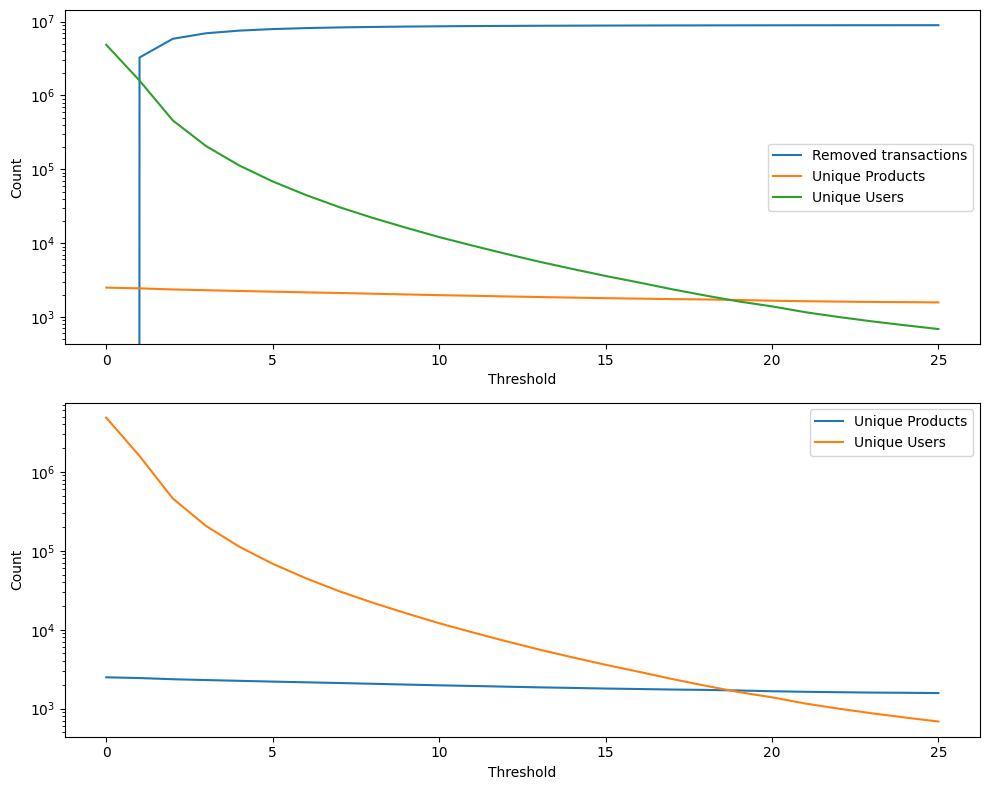

Saved hitting
{50000: 49, 100000: 35}


In [14]:
# Chart how many books are removed if treshhold increases from 20 - 200 by 10

import matplotlib.pyplot as plt

removed_transactions = [0]
unique_books = [len(transactions_products["product_id"].unique())]
unique_products = [len(transactions_products["user_id"].unique())]
array_counts = []
save_hitting = {50000: None, 100000: None} #50 000 and 100 000
MULTIPLIER_BOOKS = 2
for i in range(1, 100, 2):
    # user_treshhold, product_treshold, original_transactions, products, save_as_append=""):
    transactions, _ = clean_with_treshhold(i, i*MULTIPLIER_BOOKS, transactions_products, products_books)
    # print(i, len(transactions_books) - len(transactions)) 
    removed_transactions.append(len(transactions_products) - len(transactions))
    unique_books.append(len(transactions["product_id"].unique()))
    unique_products.append(len(transactions["user_id"].unique()))
    array_counts.append({"treshhold users": i, "treshhold products": i*MULTIPLIER_BOOKS, "transactions count": len(transactions), "removed_transactions": len(transactions_products) - len(transactions), "unique_products": len(transactions["product_id"].unique()), "unique_users": len(transactions["user_id"].unique() )})
    # if len(transactions) > 50000 and save_hitting[50000] is None:
    #     save_hitting[50000] = i
    # if len(transactions) > 100000 and save_hitting[100000] is None:
    #     save_hitting[100000] = i
    for key in save_hitting.keys():
        if len(transactions) < key and save_hitting[key] is None:
            save_hitting[key] = i
    # If all save hitting is found, break
    if all(value is not None for value in save_hitting.values()):
        break

# Create subplots with 2 rows and 1 column
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot the removed transactions, unique books, and unique users on the first subplot
ax1.plot(removed_transactions)
ax1.plot(unique_books)
ax1.plot(unique_products)

# Plot a closer look at unique books and unique users on the second subplot
ax2.plot(unique_books)
ax2.plot(unique_products)

# Set labels and legend
ax1.legend(["Removed transactions", "Unique Products", "Unique Users"])
ax1.set_xlabel("Threshold")
ax1.set_ylabel("Count")

ax2.legend(["Unique Products", "Unique Users"])
ax2.set_xlabel("Threshold")
ax2.set_ylabel("Count")


# Set y-axis to logarithmic scale
ax1.set_yscale('log')
ax2.set_yscale('log')

plt.tight_layout()
plt.show()

# show dataframe.
df_counts = pd.DataFrame(array_counts)
df_counts.head(10)
print('Saved hitting')
pprint.pprint(save_hitting)

In [15]:


DATA_CONTEXT = "games"
VERSION = "3"
OUTPUT = "data"

transactions, results_dict = clean_with_treshhold(49, 49*2, transactions_products, products_books, save_as_append=f"_{DATA_CONTEXT}", verbose=True, users_df=users_products)
pprint.pprint(results_dict)

Start count of transactions 9000000
Unique books:  2494
Unique users:  4860086
final count of transactions 46674
Unique books:  1574
Unique users:  686
{'data_context': 'games',
 'product_count': 1574,
 'product_features': ['product_id',
                      'product_title',
                      'product_price',
                      'product_soup',
                      'product_tags',
                      'count',
                      'id'],
 'product_filepath': 'data/products_games_v3_t49_p98.csv',
 'product_unique_count': 1574,
 'transaction_count': 46674,
 'transaction_features': ['id', 'user_id', 'product_id', 'rate'],
 'transactions_filepath': 'data/transactions_games_v3_t49_p98.csv',
 'unique_name': '_games_v3_t49_p98',
 'user_count': 686,
 'user_features': ['id', 'details_soup'],
 'user_filepath': 'data/users_games_v3_t49_p98.csv',
 'user_unique_count': 686,
 'version': '3'}
